# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'CF',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_005  Q9P2E7;Q9P2E7-2   15.264
Sample_056  Q9HCU0            17.436
Sample_107  P12318;P12318-2   17.103
Sample_144  E9PLK3;P55786     15.915
Sample_122  Q9HCB6            16.377
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups 
Sample_037  Q96AQ6;Q96AQ6-2   14.188
Sample_040  P26447            15.260
Sample_032  O00451            14.948
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.864
            A0A075B6Q5                 12.824
            A0A075B6R2                 14.377
            A0A075B6S5                 12.867
            A0A087WSY4                 13.261
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.135
            Q9UI40;Q9UI40-2            12.264
            Q9UIW2                     12.081
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.723
            Q9UP79                     11.536
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.126,15.050,16.842,19.863,16.097,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.789,19.067,...,15.528,15.576,14.546,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.779,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.665,17.705,17.039,15.286,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.192,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.664,15.345,17.084,18.708,14.249,19.433,12.000,10.868
Sample_207,15.739,16.877,15.469,16.898,14.471,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.864,...,16.012,15.178,13.415,15.050,16.842,19.863,13.477,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.554,19.067,16.188,...,15.528,15.576,13.143,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.862,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.685,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.334,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.652,15.345,17.084,18.708,14.249,19.433,13.733,12.037
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 347.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.60it/s]

100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.63it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.26it/s]

100%|██████████| 5/5 [00:00<00:00,  4.73it/s]

100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.23it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.13it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

100%|██████████| 6/6 [00:01<00:00,  4.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 10.10it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.65it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.13it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.83it/s]

100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.90it/s]

 38%|███▊      | 3/8 [00:00<00:00,  7.08it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.08it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.86it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.55it/s]

100%|██████████| 8/8 [00:01<00:00,  3.00it/s]

100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.58it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.36it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.14it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.92it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.94it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.62it/s]

100%|██████████| 9/9 [00:01<00:00,  3.97it/s]

100%|██████████| 9/9 [00:01<00:00,  4.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.69it/s]

 30%|███       | 3/10 [00:00<00:01,  6.99it/s]

 40%|████      | 4/10 [00:00<00:00,  6.43it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.86it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.44it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.49it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.53it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.47it/s]

100%|██████████| 10/10 [00:01<00:00,  5.48it/s]

100%|██████████| 10/10 [00:01<00:00,  5.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.89it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.39it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.82it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.48it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.25it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  7.16it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  7.02it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.99it/s]

100%|██████████| 11/11 [00:01<00:00,  6.93it/s]

100%|██████████| 11/11 [00:01<00:00,  7.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.98it/s]

 25%|██▌       | 3/12 [00:00<00:01,  7.42it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.62it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.23it/s]

 50%|█████     | 6/12 [00:00<00:01,  5.76it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.62it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.63it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.54it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.57it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.58it/s]

100%|██████████| 12/12 [00:02<00:00,  5.82it/s]

100%|██████████| 12/12 [00:02<00:00,  5.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.78it/s]

 31%|███       | 4/13 [00:00<00:01,  8.26it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.64it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.25it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.00it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.85it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.74it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.73it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.79it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.78it/s]

100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.91it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.52it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.77it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.35it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.05it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.82it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.82it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.81it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.80it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.79it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.83it/s]

100%|██████████| 14/14 [00:01<00:00,  6.82it/s]

100%|██████████| 14/14 [00:01<00:00,  7.18it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.88it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.34it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.79it/s]

 40%|████      | 6/15 [00:00<00:01,  7.39it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.08it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  7.00it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.91it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.74it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.72it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.71it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  6.72it/s]

100%|██████████| 15/15 [00:02<00:00,  6.77it/s]

100%|██████████| 15/15 [00:02<00:00,  7.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.046 0.013          0.756 0.355       0.114   
2             0.004 0.000      0.047 0.006          0.697 0.118       0.638   
3             0.004 0.004      0.047 0.011          0.706 0.117       0.624   
4             0.004 0.002      0.044 0.013          0.694 0.115       0.609   
5             0.003 0.001      0.040 0.008          0.727 0.108       0.647   
6             0.003 0.001      0.038 0.013          0.715 0.099       0.669   
7             0.003 0.001      0.031 0.006          0.795 0.092       0.798   
8             0.003 0.002      0.038 0.013          0.791 0.092       0.797   
9             0.003 0.001      0.044 0.019          0.797 0.091       0.804   
10            0.002 0.000      0.027 0.002          0.810 0.079       0.831   
11            0.002 0.000      0.027 0.001          0.813 0.076       0.823   
12            0.002 0.000      0.027 0.000          0.822 0.085       0.830   
13            0.002 0.000      0.027 0.000          0.821 0.085       0.825   
14            0.002 0.000      0.027 0.000          0.818 0.090       0.815   
15            0.002 0.000      0.027 0.000          0.814 0.089       0.813   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.192 0.126                  0.550 0.040        0.849   
2          0.124   0.657 0.090                  0.712 0.073        0.788   
3          0.135   0.653 0.099                  0.712 0.078        0.791   
4          0.134   0.639 0.096                  0.701 0.074        0.786   
5          0.106   0.677 0.078                  0.730 0.061        0.823   
6          0.112   0.685 0.082                  0.734 0.066        0.822   
7          0.107   0.791 0.074                  0.821 0.062        0.899   
8          0.109   0.788 0.074                  0.819 0.063        0.897   
9          0.102   0.795 0.073                  0.825 0.062        0.896   
10         0.107   0.816 0.068                  0.843 0.058        0.904   
11         0.099   0.813 0.065                  0.841 0.055        0.906   
12         0.094   0.823 0.071                  0.848 0.061        0.909   
13         0.097   0.820 0.074                  0.846 0.063        0.908   
14         0.098   0.813 0.074                  0.840 0.064        0.905   
15         0.098   0.809 0.071                  0.837 0.061        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.073                  0.731 0.092        210.000 0.000  
3          0.076                  0.729 0.095        210.000 0.000  
4          0.077                  0.718 0.097        210.000 0.000  
5          0.064                  0.784 0.088        210.000 0.000  
6          0.066                  0.779 0.092        210.000 0.000  
7          0.051                  0.878 0.060        210.000 0.000  
8          0.051                  0.876 0.060        210.000 0.000  
9          0.051                  0.876 0.058        210.000 0.000  
10         0.051                  0.890 0.056        210.000 0.000  
11         0.051                  0.895 0.056        210.000 0.000  
12         0.052                  0.900 0.053        210.000 0.000  
13         0.052                  0.899 0.053        210.000 0.000  
14         0.054                  0.896 0.055        210.000 0.000  
15         0.053                  0.894 0.056 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 646.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.34it/s]

100%|██████████| 2/2 [00:00<00:00, 11.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.36it/s]

100%|██████████| 3/3 [00:00<00:00,  8.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.45it/s]

100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.40it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.22it/s]

100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.36it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.07it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.59it/s]

100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.28it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.35it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.74it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.39it/s]

100%|██████████| 7/7 [00:01<00:00,  6.16it/s]

100%|██████████| 7/7 [00:01<00:00,  6.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.46it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.24it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.73it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.15it/s]

100%|██████████| 8/8 [00:01<00:00,  6.00it/s]

100%|██████████| 8/8 [00:01<00:00,  6.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.40it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.05it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.56it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.25it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.06it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.93it/s]

100%|██████████| 9/9 [00:01<00:00,  5.85it/s]

100%|██████████| 9/9 [00:01<00:00,  6.33it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.60it/s]

 40%|████      | 4/10 [00:00<00:00,  7.01it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.64it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.29it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.09it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.96it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.85it/s]

100%|██████████| 10/10 [00:01<00:00,  5.85it/s]

100%|██████████| 10/10 [00:01<00:00,  6.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.42it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.31it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.73it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.32it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.05it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.98it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.93it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.81it/s]

100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

100%|██████████| 11/11 [00:01<00:00,  6.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.21it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.13it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.62it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.24it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.13it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.99it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.90it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.84it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.78it/s]

100%|██████████| 12/12 [00:01<00:00,  5.74it/s]

100%|██████████| 12/12 [00:01<00:00,  6.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.34it/s]

 31%|███       | 4/13 [00:00<00:01,  7.26it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.69it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.33it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.12it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.95it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.83it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.78it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.75it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.73it/s]

100%|██████████| 13/13 [00:02<00:00,  5.73it/s]

100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.42it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.32it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.70it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.18it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.03it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.93it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.87it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.81it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.77it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.73it/s]

100%|██████████| 14/14 [00:02<00:00,  5.73it/s]

100%|██████████| 14/14 [00:02<00:00,  6.15it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.45it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.16it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.64it/s]

 40%|████      | 6/15 [00:00<00:01,  6.33it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.11it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.84it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.77it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.74it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.73it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.70it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.66it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.74it/s]

100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.026 0.000          0.606 0.119       0.390   
3             0.002 0.000      0.026 0.000          0.680 0.087       0.494   
4             0.002 0.000      0.026 0.000          0.649 0.101       0.492   
5             0.002 0.000      0.026 0.000          0.713 0.098       0.601   
6             0.002 0.000      0.026 0.000          0.743 0.084       0.720   
7             0.002 0.000      0.027 0.000          0.762 0.085       0.729   
8             0.002 0.000      0.027 0.000          0.746 0.085       0.725   
9             0.002 0.000      0.027 0.000          0.763 0.089       0.741   
10            0.002 0.000      0.026 0.000          0.745 0.087       0.753   
11            0.002 0.000      0.027 0.000          0.754 0.080       0.755   
12            0.002 0.000      0.026 0.000          0.776 0.082       0.792   
13            0.002 0.000      0.027 0.000          0.777 0.077       0.794   
14            0.002 0.000      0.027 0.000          0.789 0.074       0.808   
15            0.002 0.000      0.026 0.000          0.784 0.075       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.118   0.465 0.104                  0.601 0.059        0.679   
3          0.120   0.562 0.092                  0.660 0.054        0.699   
4          0.121   0.550 0.095                  0.646 0.061        0.693   
5          0.114   0.645 0.085                  0.710 0.061        0.779   
6          0.095   0.726 0.067                  0.767 0.055        0.875   
7          0.109   0.739 0.073                  0.779 0.058        0.881   
8          0.109   0.730 0.076                  0.771 0.061        0.879   
9          0.119   0.747 0.086                  0.786 0.069        0.882   
10         0.107   0.745 0.079                  0.782 0.064        0.885   
11         0.103   0.752 0.077                  0.788 0.063        0.895   
12         0.117   0.780 0.085                  0.813 0.071        0.912   
13         0.118   0.781 0.082                  0.813 0.068        0.911   
14         0.121   0.794 0.081                  0.825 0.068        0.912   
15         0.120   0.790 0.080                  0.822 0.066        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.086        210.000 0.000  
2          0.085                  0.628 0.095        210.000 0.000  
3          0.068                  0.664 0.071        210.000 0.000  
4          0.070                  0.652 0.078        210.000 0.000  
5          0.066                  0.748 0.083        210.000 0.000  
6          0.048                  0.854 0.057        210.000 0.000  
7          0.046                  0.850 0.063        210.000 0.000  
8          0.047                  0.849 0.064        210.000 0.000  
9          0.047                  0.851 0.064        210.000 0.000  
10         0.049                  0.859 0.062        210.000 0.000  
11         0.044                  0.874 0.051        210.000 0.000  
12         0.044                  0.895 0.049        210.000 0.000  
13         0.043                  0.895 0.049        210.000 0.000  
14         0.041                  0.894 0.048        210.000 0.000  
15         0.039                  0.894 0.045 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1384.72it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 56.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 40.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.41it/s]

100%|██████████| 4/4 [00:00<00:00, 37.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 37.80it/s]

100%|██████████| 5/5 [00:00<00:00, 34.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 38.33it/s]

100%|██████████| 6/6 [00:00<00:00, 34.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 38.42it/s]

100%|██████████| 7/7 [00:00<00:00, 33.62it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 38.60it/s]

100%|██████████| 8/8 [00:00<00:00, 32.44it/s]

100%|██████████| 8/8 [00:00<00:00, 33.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 38.69it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 30.66it/s]

100%|██████████| 9/9 [00:00<00:00, 31.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 37.40it/s]

 80%|████████  | 8/10 [00:00<00:00, 31.98it/s]

100%|██████████| 10/10 [00:00<00:00, 31.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 36.94it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.98it/s]

100%|██████████| 11/11 [00:00<00:00, 31.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 38.55it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 30.93it/s]

100%|██████████| 12/12 [00:00<00:00, 29.75it/s]

100%|██████████| 12/12 [00:00<00:00, 30.60it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 37.52it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 30.85it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 29.01it/s]

100%|██████████| 13/13 [00:00<00:00, 29.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 38.74it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.89it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 28.91it/s]

100%|██████████| 14/14 [00:00<00:00, 29.66it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 38.23it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 32.32it/s]

 80%|████████  | 12/15 [00:00<00:00, 30.83it/s]

100%|██████████| 15/15 [00:00<00:00, 31.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.003          0.000 0.000       0.000   
2             0.002 0.000      0.026 0.000          0.000 0.000       0.000   
3             0.002 0.000      0.026 0.000          0.177 0.313       0.023   
4             0.002 0.000      0.027 0.000          0.686 0.092       0.612   
5             0.002 0.000      0.026 0.000          0.677 0.089       0.607   
6             0.002 0.000      0.026 0.000          0.672 0.090       0.606   
7             0.002 0.000      0.026 0.000          0.664 0.070       0.653   
8             0.002 0.000      0.026 0.000          0.657 0.070       0.640   
9             0.002 0.000      0.026 0.000          0.644 0.061       0.617   
10            0.002 0.000      0.026 0.000          0.664 0.080       0.633   
11            0.002 0.000      0.026 0.000          0.661 0.081       0.634   
12            0.002 0.000      0.026 0.000          0.679 0.073       0.646   
13            0.002 0.000      0.026 0.000          0.704 0.085       0.679   
14            0.002 0.000      0.026 0.000          0.705 0.083       0.682   
15            0.002 0.000      0.026 0.001          0.703 0.084       0.662   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.754   
2          0.000   0.000 0.000                  0.499 0.006        0.603   
3          0.038   0.039 0.064                  0.499 0.024        0.548   
4          0.118   0.640 0.089                  0.702 0.067        0.794   
5          0.123   0.634 0.090                  0.697 0.066        0.788   
6          0.126   0.630 0.091                  0.694 0.067        0.785   
7          0.131   0.652 0.087                  0.706 0.065        0.806   
8          0.130   0.642 0.088                  0.698 0.063        0.802   
9          0.118   0.626 0.080                  0.685 0.059        0.804   
10         0.109   0.644 0.078                  0.699 0.062        0.811   
11         0.110   0.643 0.081                  0.698 0.063        0.808   
12         0.111   0.657 0.074                  0.710 0.058        0.816   
13         0.102   0.686 0.072                  0.733 0.059        0.824   
14         0.104   0.688 0.072                  0.734 0.059        0.825   
15         0.101   0.676 0.072                  0.726 0.058        0.825   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.701 0.083        210.000 0.000  
2          0.122                  0.574 0.111        210.000 0.000  
3          0.103                  0.507 0.095        210.000 0.000  
4          0.062                  0.751 0.076        210.000 0.000  
5          0.062                  0.741 0.077        210.000 0.000  
6          0.064                  0.737 0.081        210.000 0.000  
7          0.064                  0.758 0.079        210.000 0.000  
8          0.066                  0.756 0.081        210.000 0.000  
9          0.062                  0.757 0.075        210.000 0.000  
10         0.062                  0.767 0.080        210.000 0.000  
11         0.063                  0.763 0.079        210.000 0.000  
12         0.059                  0.775 0.073        210.000 0.000  
13         0.060                  0.786 0.068        210.000 0.000  
14         0.060                  0.776 0.072        210.000 0.000  
15         0.060                  0.775 0.073 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,15,15
score_time,2,11,1
test_precision,12,14,14
test_recall,10,14,14
test_f1,12,14,14
test_balanced_accuracy,12,14,14
test_roc_auc,12,14,14
test_average_precision,12,12,13
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.43it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.24it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.72it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.39it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.20it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.04it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.93it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.96it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.96it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.89it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.83it/s]

100%|██████████| 14/14 [00:02<00:00,  5.78it/s]

100%|██████████| 14/14 [00:02<00:00,  6.21it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 38.61it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 31.89it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.50it/s]

100%|██████████| 14/14 [00:00<00:00, 30.04it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.82it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.44it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.73it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.45it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.25it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  7.11it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.91it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.89it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.80it/s]

100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

100%|██████████| 12/12 [00:01<00:00,  7.31it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


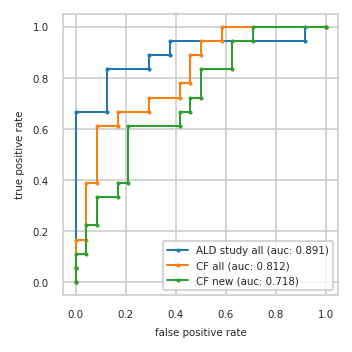

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.667  0.000 0.167  0.000 0.111
3          0.125 0.667  0.042 0.167  0.042 0.111
4          0.125 0.833  0.042 0.389  0.042 0.222
5          0.292 0.833  0.083 0.389  0.083 0.222
6          0.292 0.889  0.083 0.611  0.083 0.333
7          0.375 0.889  0.167 0.611  0.167 0.333
8          0.375 0.944  0.167 0.667  0.167 0.389
9          0.917 0.944  0.292 0.667  0.208 0.389
10         0.917 1.000  0.292 0.722  0.208 0.611
11         1.000 1.000  0.417 0.722  0.417 0.611
12           NaN   NaN  0.417 0.778  0.417 0.667
13           NaN   NaN  0.458 0.778  0.458 0.667
14           NaN   NaN  0.458 0.889  0.458 0.722
15           NaN   NaN  0.500 0.889  0.500 0.722
16           NaN   NaN  0.500 0.944  0.500 0.833
17           NaN   NaN  0.583 0.944  0.625 0.833
18           NaN   NaN  0.583 1.000  0.625 0.944
19           NaN   NaN  1.000 1.000  0.708 0.944
20           NaN   NaN    NaN   NaN  0.708 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,Q641Q3;Q641Q3-2,P08253,P31321
3,P61981,Q04760;Q04760-2,P51688
4,P14174,P04075,Q96GD0
5,P04075,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
6,C9JF17;P05090,P14174,J3KSJ8;Q9UD71;Q9UD71-2
7,Q9Y2T3;Q9Y2T3-3,Q14894,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
8,Q6EMK4,P61981,D6R956;P09936


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


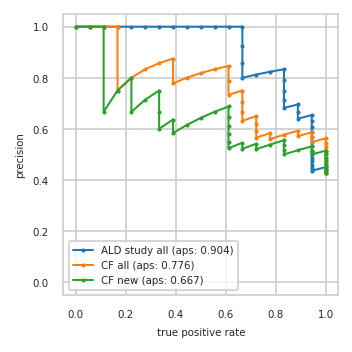

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.640 0.889     0.560 0.778     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.696 0.889     0.565 0.722     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.667 0.667     0.611 0.611
25         0.824 0.778     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.923 0.667     0.846 0.611     0.615 0.444
30         1.000 0.667     0.833 0.556     0.583 0.389
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.667 0.333
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


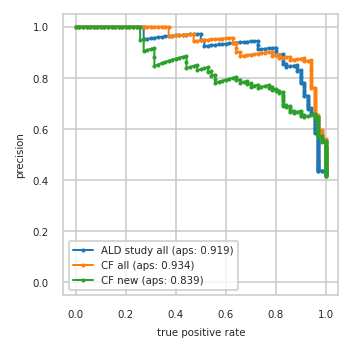

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


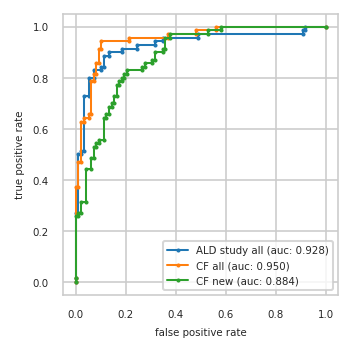

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

Output files:

In [36]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}